# Covid 19 experiments


In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import pathlib, json
import torch
import os
import pandas as pd
import numpy as np
import pickle, sys
import warnings
from tqdm import tqdm
from sklearn.model_selection import KFold

sys.path.append('../')
sys.path.append('../../')

from recipes.dataset import MCPASDataset
import warnings

warnings.filterwarnings('ignore')

# from analysis_util import display_mat_from_ind
# from analysis_util import convert_len

from Bio.PDB import *

from pdb_util import get_chain_list, calc_dist, remove_HOH #, get_structure_from_id
# get_structure_from_id, from_str_to_chain_names, get_residues_from_names
# from pdb_util import get_cdrs_from_anarci
# from pdb_util import get_seqs_from_residues
warnings.filterwarnings(action='once')


def display_mat_from_ind(ind, wantdisplay=False):
    attn_output_weights1, attn_output_weights2, abseq_with_comma, peptide, ypred, sign = ATTENTION_MATRIX_DICT[ind]
    aseq = DF_TCR.iloc[ind]['tcra']
    bseq = DF_TCR.iloc[ind]['tcrb']
    abseq = convert_len(aseq, MAXLENGTH_A) + convert_len(bseq, MAXLENGTH_B)
    peptide = convert_len(DF_TCR.iloc[ind]['peptide'], max_len_epitope)

    attn_output_weights2_list = []
    for head_i in range(4):
        a = attn_output_weights2[head_i]
        dfa = pd.DataFrame(a)
        dfa.insert(27, "delimiter", [0.1**9 for _ in range(len(dfa))])
        dfa = dfa.loc[:, ((dfa!=0).sum()!=0).values]
        dfa.columns = [f'{c}_{i}' for i,c in enumerate(list(abseq_with_comma))]
        dfa = dfa.head(len(peptide.replace('8','')))
        dfa.index = list(peptide.replace('8',''))
        dfa.index = [f'{ind}_{i}' for i,ind in enumerate(dfa.index)]
        if wantdisplay:
            display(px.imshow(dfa, width=800, height=480))
        attn_output_weights2_list.append(dfa)

    abseq_index = convert_len(aseq, MAXLENGTH_A) + ':' + convert_len(bseq, MAXLENGTH_B)

    attn_output_weights1_list = []
    for head_i in range(4):
        a = attn_output_weights1[head_i]
        dfa = pd.DataFrame(a).T
        dfa.insert(27, "delimiter", [0.1**9 for _ in range(len(dfa))])
        dfa = dfa.T
        dfa = dfa.loc[:, ((dfa!=0).sum()!=0).values]
        dfa.index = [f'{c}_{i}' for i,c in enumerate(list(abseq_index))]

        dfa.columns = [f'{ind}_{i}' for i,ind in enumerate(peptide)]
        selector_columns = [c for c in dfa.columns if '8_' not in c]
        selector_index = [c for c in dfa.index if '8_' not in c]
        dfa = dfa.loc[selector_index]
        dfa.index = [f'{c}_{i}' for i,c in enumerate(abseq_with_comma)]
        dfa = dfa[selector_columns]
        if wantdisplay:
            display(px.imshow(dfa, width=800, height=480))
        attn_output_weights1_list.append(dfa)
    return attn_output_weights1_list, attn_output_weights2_list

def convert_len(seq, maxlen):
    if len(seq) >= maxlen:
        return seq[:maxlen]
    else:  # padding
        pad = '8' * int(maxlen - len(seq))
        return seq + pad
    


def remove_UNK_and_take_subset(df_train):
    df_nounk = df_train[df_train['tcra']!='UNK']
    print("df_nounk.value_counts() \n\t ", df_nounk.sign.value_counts().to_dict())
    print("df_nounk.drop_duplicates('tcrb') \n\t ", df_nounk.drop_duplicates('tcrb').sign.value_counts().to_dict())
    return df_nounk


def get_df(datapath):
    return pd.DataFrame(pickle.load(open(datapath, "rb")))

def get_df_from_path(p_list):
    return pd.concat([get_df(d) for d in p_list]).reset_index(drop=True)

def split_and_get_first(a):
    if ',' in a:
        a = a.split(',')[0]
    return a


In [4]:
!ls ../data/

all_tcrs_a.fasta         jem_20211327_tables3.csv
all_tcrs_b.fasta         tcr_with_crystal.csv


# Data

In [5]:
jem_20211327_tables3 = pd.read_csv('../data/jem_20211327_tables3.csv')

In [6]:
jem_20211327_tables3

,Seurat barcode,GEX.Cluster,Patient.ID,Stimulation,Patient,Patient.Disease Severity,TRAV,CDR3.alpha,TRAJ,TRAC,...,Public clonotype in Figure 3A,Occurrence in Healthy,Occurrence in Covid19,log2(Occurrence in Covid19 / Healthy),#Patients in Healthy,#Patients in Covid19,avg.log10(Expansion) in Healthy,avg.log10(Expansion) in Covid19,log10Expansion (Covid19 - Healthy),p-val
0,DB2_CAGGTGCTCTCCGGTT,8,Ts-017,recombinant S protein,Ts-017,4,TRAV12-1,CVVNRGSSYKLIF,TRAJ12,TRAC,...,#5 TCR-017,0.0636,0.1352,1.0874,50.0,191.0,-5.3578,-5.2351,0.1227,0.1081
1,DB3_CGATTGAGTTACTGAC,8,Ts-018,inactivated virus,Ts-018,2,TRAV12-3,CAMTYSGGYQKVTF,TRAJ13,TRAC,...,#3,0.0598,0.1507,1.3340,47.0,213.0,-5.4960,-5.1993,0.2967,0.0001
2,DB2_TGAGCCGGTAGAGCTG,8,Ts-017,Peptide pool S,Ts-017,4,TRAV21,CALKGSDYKLSF,TRAJ20,TRAC,...,NaN,0.0038,0.0510,3.7388,3.0,72.0,-5.3972,-4.7881,0.6091,0.1516
3,DB10_TTGCGTCTCTCGATGA,8,Ts-025#2,recombinant S protein,Ts-025,2,TRAV22,CAVDSGTSYGKLTF,TRAJ52,TRAC,...,NaN,0.2099,0.1734,-0.2758,165.0,245.0,-5.3819,-5.3901,-0.0082,0.8317
4,DB10_GTGCATATCGACGGAA,8,Ts-025,recombinant S protein,Ts-025,2,TRAV12-3,CAMTPSGGYQKVTF,TRAJ13,TRAC,...,#3,0.0598,0.1507,1.3340,47.0,213.0,-5.4960,-5.1993,0.2967,0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,DB7_ACTTGTTAGCCTTGAT,8,Ts-010#2,recombinant S protein,Ts-010,3,TRAV8-6,CAVSSSGGTSYGKLTF,TRAJ52,TRAC,...,NaN,0.0013,0.0050,1.9612,1.0,7.0,-5.8426,-5.6858,0.1568,NaN
1880,DB7_ACTGCTCTCCCAAGAT,8,Ts-010,inactivated virus,Ts-010,3,TRAV2,CAVGADYKLSF,TRAJ20,TRAC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1881,DB7_ACGTCAAGTGAGTGAC,8,Ts-010,Peptide pool S,Ts-010,3,TRAV8-4,CAVSRYGAGGGNKLTF,TRAJ10,TRAC,...,NaN,0.0013,0.0000,-inf,1.0,0.0,-5.4795,NaN,NaN,NaN
1882,DB7_ACGGGTCGTACCATCA,8,Ts-010,Peptide pool M+N,Ts-010,3,TRAV12-1,CVVNPQGSGNTGKLIF,TRAJ37,TRAC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_clonotypes10 = jem_20211327_tables3[jem_20211327_tables3['Public clonotype in Figure 3A'].notna()]
df_clonotypes10 = df_clonotypes10.drop_duplicates(subset=['CDR3.alpha', 'CDR3.beta'])
df_clonotypes10 = df_clonotypes10.sort_values(by=['Public clonotype in Figure 3A']).dropna()
df_clonotypes10[['CDR3.alpha', 'CDR3.beta', 'Public clonotype in Figure 3A']]
df_clonotypes10

,Seurat barcode,GEX.Cluster,Patient.ID,Stimulation,Patient,Patient.Disease Severity,TRAV,CDR3.alpha,TRAJ,TRAC,...,Public clonotype in Figure 3A,Occurrence in Healthy,Occurrence in Covid19,log2(Occurrence in Covid19 / Healthy),#Patients in Healthy,#Patients in Covid19,avg.log10(Expansion) in Healthy,avg.log10(Expansion) in Covid19,log10Expansion (Covid19 - Healthy),p-val
60,DB9_ACACCAACAATGTAAG,8,Ts-009,inactivated virus,Ts-009,4,TRAV2,CAALNAGNMLTF,TRAJ39,TRAC,...,#1,0.0064,0.0616,3.2749,5.0,87.0,-5.4312,-5.1065,0.3247,0.1998
1366,DB3_TCAGGTAGTGGCAAAC,8,Ts-018,Peptide pool S,Ts-018,2,TRAV8-2,CVVSRTGGGNKLTF,TRAJ10,TRAC,...,#1,0.1399,0.2088,0.5771,110.0,295.0,-5.3877,-5.0642,0.3235,0.0000
666,DB10_GTTCGGGCAAACCCAT,8,Ts-025,Peptide pool S,Ts-025,2,TRAV13-1,CAAGYALNF,TRAJ41,TRAC,...,#10,0.0153,0.0248,0.6982,12.0,35.0,-5.5338,-5.2348,0.2990,0.0284
795,DB9_GTGCGGTCAGTTTACG,8,Ts-009#2,recombinant S protein,Ts-009,4,TRAV12-1,CVVNKGSSASKIIF,TRAJ3,TRAC,...,#2,0.0305,0.1380,2.1762,24.0,195.0,-5.4218,-4.6512,0.7706,0.0000
1,DB3_CGATTGAGTTACTGAC,8,Ts-018,inactivated virus,Ts-018,2,TRAV12-3,CAMTYSGGYQKVTF,TRAJ13,TRAC,...,#3,0.0598,0.1507,1.3340,47.0,213.0,-5.4960,-5.1993,0.2967,0.0001
4,DB10_GTGCATATCGACGGAA,8,Ts-025,recombinant S protein,Ts-025,2,TRAV12-3,CAMTPSGGYQKVTF,TRAJ13,TRAC,...,#3,0.0598,0.1507,1.3340,47.0,213.0,-5.4960,-5.1993,0.2967,0.0001
577,DB10_GACTGCGCACCATCCT,8,Ts-025,recombinant S protein,Ts-025,2,TRAV8-4,CAVSDQGRDDKIIF,TRAJ30,TRAC,...,#4,0.0204,0.1656,3.0242,16.0,234.0,-5.4771,-5.0026,0.4746,0.0003
0,DB2_CAGGTGCTCTCCGGTT,8,Ts-017,recombinant S protein,Ts-017,4,TRAV12-1,CVVNRGSSYKLIF,TRAJ12,TRAC,...,#5 TCR-017,0.0636,0.1352,1.0874,50.0,191.0,-5.3578,-5.2351,0.1227,0.1081
1372,DB3_TACAGTGCAGGAATCG,8,Ts-018,Peptide pool S,Ts-018,2,TRAV12-1,CVVNRGSSYKLIF,TRAJ12,TRAC,...,#5 TCR-018,0.1221,0.1529,0.3238,96.0,216.0,-5.4360,-5.3380,0.0979,0.0286
1021,DB4_TCAGCAATCTGGGCCA,8,Ts-002#2,Peptide pool S,Ts-002,4,TRAV13-2,CAENSGGSNYKLTF,TRAJ53,TRAC,...,#6,0.0153,0.0878,2.5231,12.0,124.0,-5.4641,-5.0426,0.4215,0.0063


# Model

In [8]:
# dt = "20211029_011638" #logdf.checkp[0].split('/')[-1]

dt = '20220211_191954'

In [9]:
!find ./ -name "20220211_191954_attention_matrix_dict.pickle"

In [10]:
AACODES = pd.read_csv('../analysis/aa_codes.csv')
AACODES['Abbreviation'] = AACODES['Abbreviation'].apply(lambda a: a.upper())
AACODES_DICT = {row['Abbreviation']:row['1 letter abbreviation'] for i, row in AACODES.iterrows()}
KFOLD_I = 0

print('dt', dt)
OUT_DIR = '../analysis/../../../tcr_attention_cachedir'


dt 20220211_191954


In [11]:
with open(f"../analysis/../hpo_params/optuna_best.json", "r") as fp:
    hparams = json.load(fp)

# Get model and dataloader 


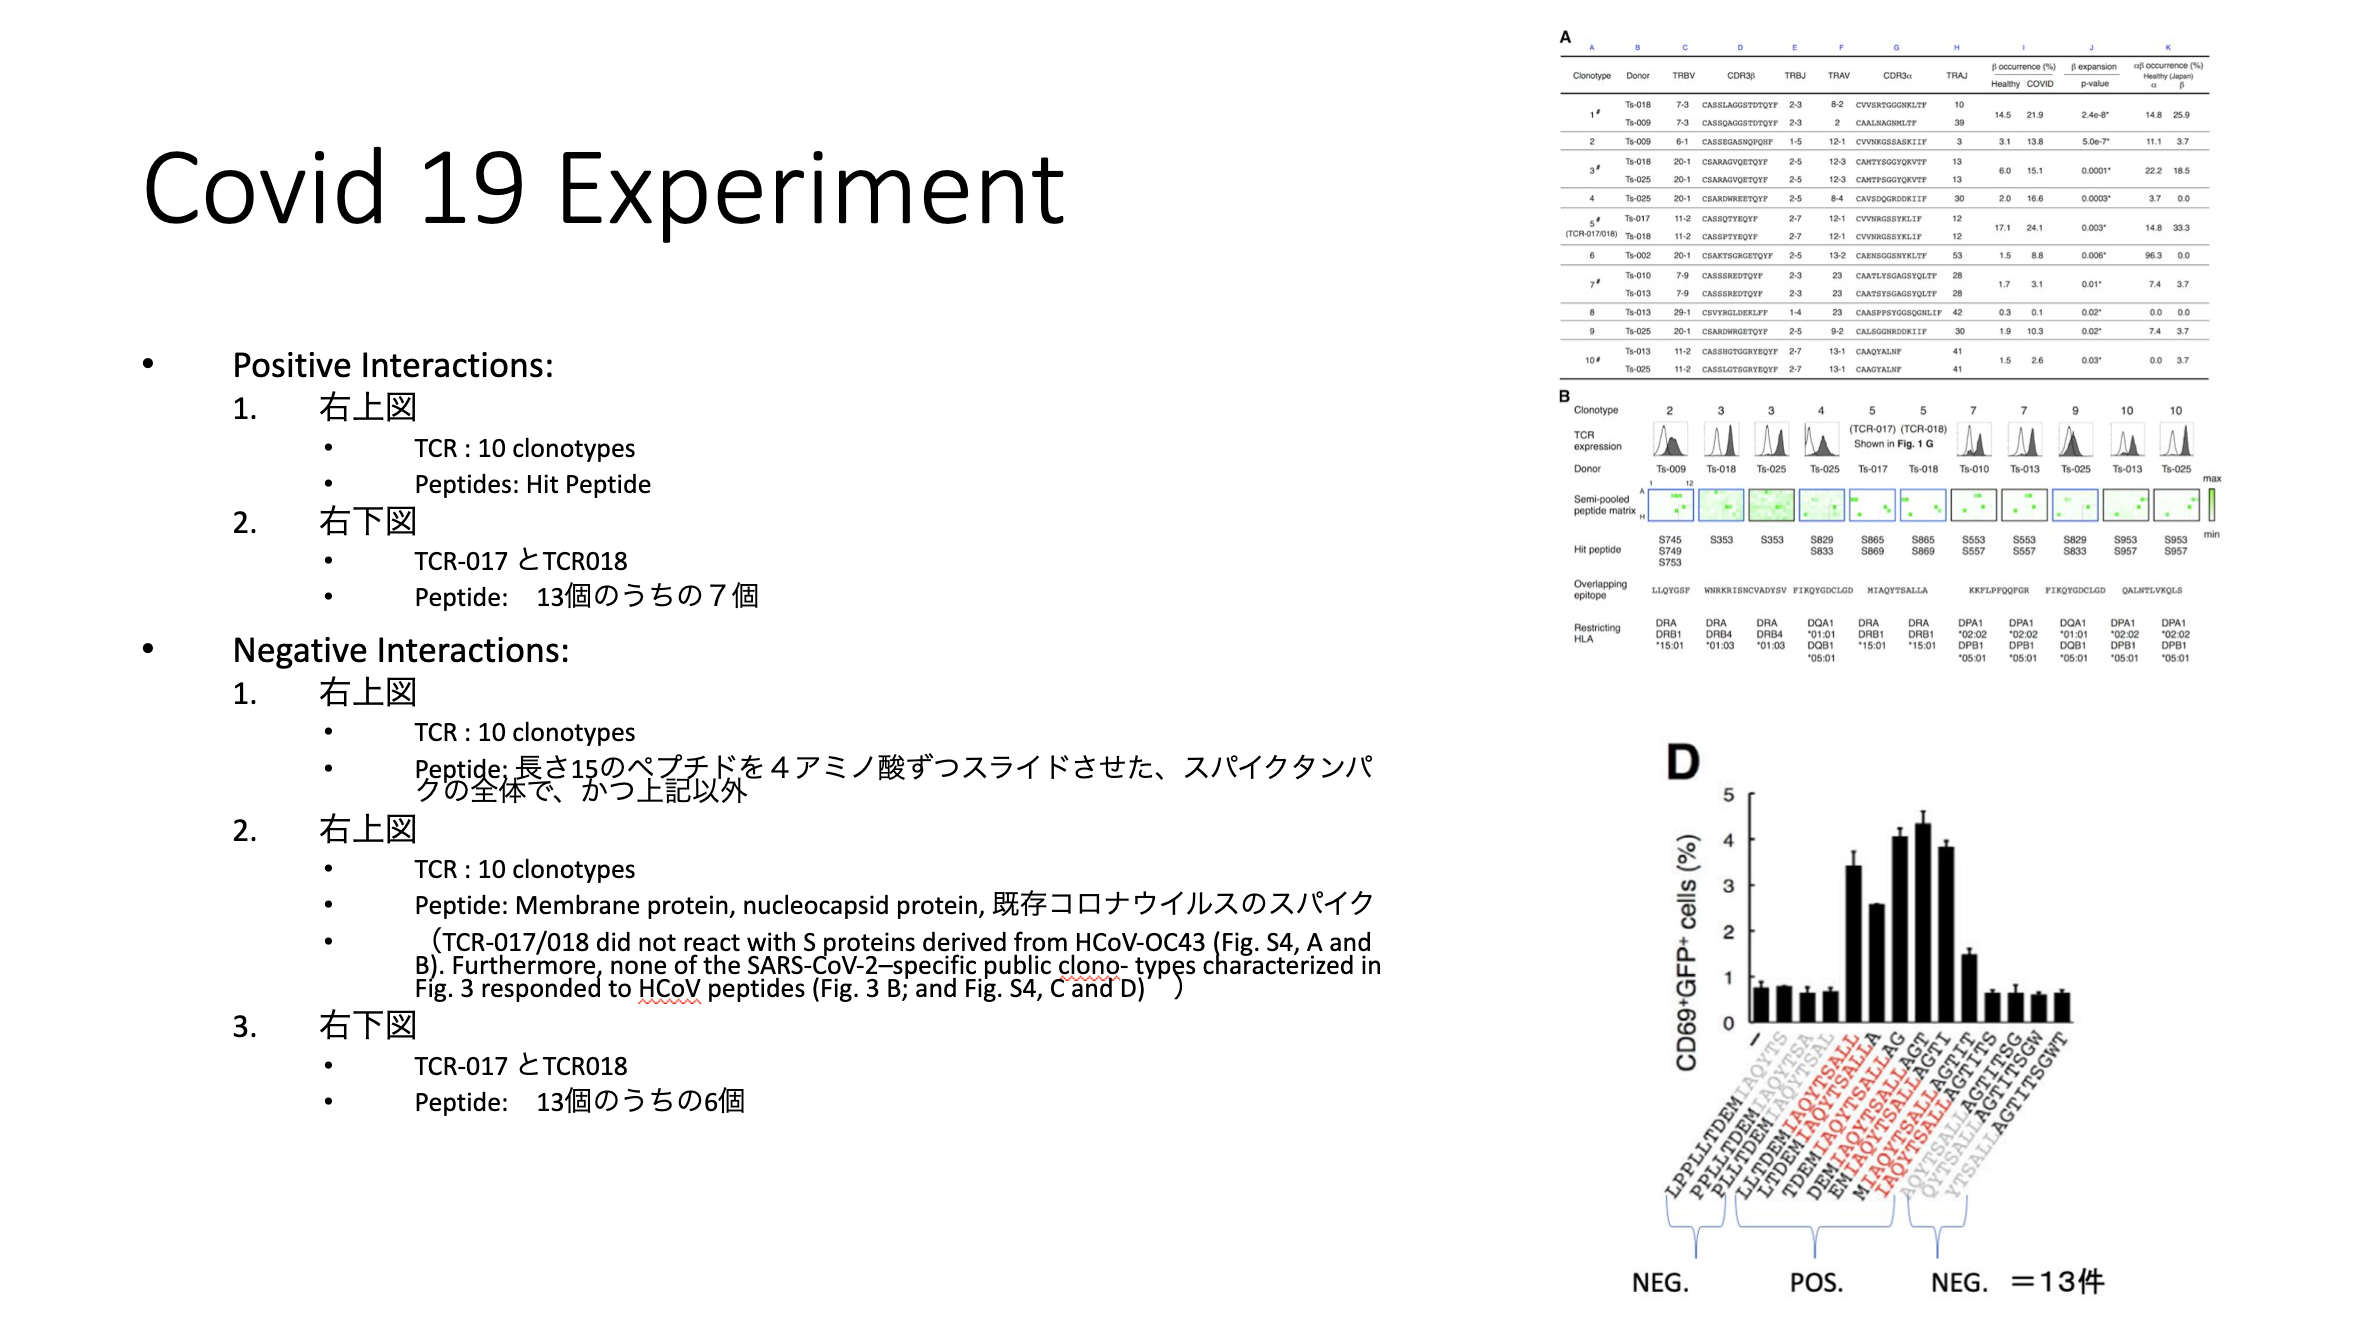
https://rupress.org/jem/article/218/12/e20211327/212701/

In [12]:
all_spike_protein = '''
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFS
NVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIV
NNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLE
GKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQT
LLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETK
CTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISN
CVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIAD
YNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPC
NGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVN
FNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITP
GTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSY
ECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTI
SVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQE
VFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDC
LGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAM
QMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALN
TLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRA
SANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPA
ICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDP
LQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDL
QELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDD
SEPVLKGVKLHYT
'''.replace('\n','')

# Spike
https://rest.uniprot.org/uniprotkb/P0DTC2.fasta

In [13]:
df_clonotypes10['Public clonotype in Figure 3A'].unique()

array(['#1', '#10', '#2', '#3', '#4', '#5 TCR-017', '#5 TCR-018', '#6',
       '#7', '#8', '#9'], dtype=object)

In [14]:
df_clonotypes10.head(2)

,Seurat barcode,GEX.Cluster,Patient.ID,Stimulation,Patient,Patient.Disease Severity,TRAV,CDR3.alpha,TRAJ,TRAC,...,Public clonotype in Figure 3A,Occurrence in Healthy,Occurrence in Covid19,log2(Occurrence in Covid19 / Healthy),#Patients in Healthy,#Patients in Covid19,avg.log10(Expansion) in Healthy,avg.log10(Expansion) in Covid19,log10Expansion (Covid19 - Healthy),p-val
60,DB9_ACACCAACAATGTAAG,8,Ts-009,inactivated virus,Ts-009,4,TRAV2,CAALNAGNMLTF,TRAJ39,TRAC,...,#1,0.0064,0.0616,3.2749,5.0,87.0,-5.4312,-5.1065,0.3247,0.1998
1366,DB3_TCAGGTAGTGGCAAAC,8,Ts-018,Peptide pool S,Ts-018,2,TRAV8-2,CVVSRTGGGNKLTF,TRAJ10,TRAC,...,#1,0.1399,0.2088,0.5771,110.0,295.0,-5.3877,-5.0642,0.3235,0.0000


In [15]:
DICT_TARGET_PEPTIDE = {} 
for i in [745, 749, 753, # 2
          353,  # 3
          829,833, # 4
          865,869, # 5
          553,557, # 7
          829,833,  # 9
          953,957,  # 10
         ]:
    DICT_TARGET_PEPTIDE[i] = all_spike_protein[i-1:i-1+15]

DICT_clonotype_to_HITpeptide = {'#2':[745, 749, 753],
                                '#3':[353],
                                '#4':[829,833],
                                '#5':[865,869],
                                '#5 TCR-017':[865,869],
                                '#5 TCR-018':[865,869],
                                '#7':[553,557],
                                '#9':[829,833],
                                '#10':[953,957],
                                '#1':[],
                                '#6':[],
                                '#8':[],
                               }

In [16]:
DICT_TARGET_PEPTIDE

{745: 'DSTECSNLLLQYGSF',
 749: 'CSNLLLQYGSFCTQL',
 753: 'LLQYGSFCTQLNRAL',
 353: 'WNRKRISNCVADYSV',
 829: 'ADAGFIKQYGDCLGD',
 833: 'FIKQYGDCLGDIAAR',
 865: 'LTDEMIAQYTSALLA',
 869: 'MIAQYTSALLAGTIT',
 553: 'TESNKKFLPFQQFGR',
 557: 'KKFLPFQQFGRDIAD',
 953: 'NQNAQALNTLVKQLS',
 957: 'QALNTLVKQLSSNFG'}

In [17]:
df_clonotypes10['HIT Peptide num'] = df_clonotypes10['Public clonotype in Figure 3A'].map(DICT_clonotype_to_HITpeptide)
df_clonotypes10['HIT Peptide seq'] = df_clonotypes10['HIT Peptide num'].apply(lambda lis: [DICT_TARGET_PEPTIDE[i] for i in lis])


## df_Pos10clonotypes_X_Hitpeptides

`10 clonotypes` x `Hit peptides`

In [18]:
all_pos_interactions = []
for i, row in df_clonotypes10[['CDR3.alpha', 'CDR3.beta', 'HIT Peptide seq']].iterrows():
    for hit in row['HIT Peptide seq']:
        temp = (row['CDR3.alpha'], row['CDR3.beta'], hit)
        all_pos_interactions.append(temp)
        

df_Pos10clonotypes_X_Hitpeptides = pd.DataFrame(all_pos_interactions, columns=['tcra','tcrb','peptide'])
df_Pos10clonotypes_X_Hitpeptides['sign'] = 1

df_Pos10clonotypes_X_Hitpeptides['source'] = 'df_Pos10clonotypes_X_Hitpeptides'

## df_PosNeg_clonotypeNo5_X_peptides


`clonotype #5` x `Hit peptides`

In [19]:
df_5 = df_clonotypes10[
    (df_clonotypes10["Public clonotype in Figure 3A"]=="#5 TCR-017") |
    (df_clonotypes10["Public clonotype in Figure 3A"]=="#5 TCR-018")].copy()

TOTAL_PEPTIDE = 'LPPLLTDEMIAQYTSALLAGTITSGWT'

all_epitopes = [TOTAL_PEPTIDE[i:i+15] for i in range(13)]

positive_epitopes = all_epitopes[3:10]
negative_epitopes = all_epitopes[:3] + all_epitopes[10:]


df_list = []

for peptide in positive_epitopes:
    df_5['peptide'] = peptide
    df_5['sign'] = 1.0
    df_list.append(df_5.copy())
    
for peptide in negative_epitopes:
    df_5['peptide'] = peptide
    df_5['sign'] = 0.0
    df_list.append(df_5.copy())

df_PosNeg_clonotypeNo5_X_peptides = pd.concat(df_list).rename(columns={'CDR3.alpha':'tcra', 'CDR3.beta':'tcrb'}).copy()
df_PosNeg_clonotypeNo5_X_peptides['source'] = 'df_PosNeg_clonotypeNo5_X_peptides'

all_pos_interactions = all_pos_interactions + df_PosNeg_clonotypeNo5_X_peptides.query('sign==1.0')[['tcra','tcrb','peptide']].apply(tuple, axis=1).values.tolist()


## df_Neg10clonotypes_X_Spikepeptides_exceptforthehitcombinations


`10 clonotypes` x `Spike peptides other than the Hit `

In [20]:
all_neg_interactions = []
for i in range(len(all_spike_protein)):
    if i+15 > len(all_spike_protein):
        continue
    if i%4==0:
        pep = all_spike_protein[i:i+15]
        if len(pep)<15:continue
        for i, row in df_clonotypes10.iterrows():
            temp = (row['CDR3.alpha'], row['CDR3.beta'], pep)
            
            if temp in all_pos_interactions:
                pass
            else:
                all_neg_interactions.append(temp)


df_Neg10clonotypes_X_Spikepeptides_exceptforthehitcombinations = pd.DataFrame(all_neg_interactions, columns=['tcra','tcrb','peptide'])
df_Neg10clonotypes_X_Spikepeptides_exceptforthehitcombinations['sign'] = 0.0

df_Neg10clonotypes_X_Spikepeptides_exceptforthehitcombinations['source'] = 'df_Neg10clonotypes_X_Spikepeptides_exceptforthehitcombinations'



## df_NegclonotypeNo5_X_Othercovidepeptides (Other covids)


`clonotype #5` x `Other covide peptides`

In [21]:
negative_other_covid = [
    'RMAMYTGSLIG',
    'OISGYTLAATS',
    'QISGYTTAATV',
    'RMAMYTGSLIG',

    'LKQYTSA',
    'LVEYGSF',
    'LSEYGTF',
    'LKQYTSA',

    'YYQHTDINFT-----—',
    'WERKTFSNCNENMSS',
    'WERKIFSNCNFNLST',
    'YHKHTFIVLY-----',

    'TVDVDYKSCTKG',
    'FVE-AYNNCTGG',
    'FVE-AYNNCTGG',
    'TVDADYKKCTKG',

    'QSLAGG---ITY',
    'ATYYNSWQNLLY',
    'AVYYNSWQNLLY',
    'DTFLNG---ITY',

    'SALNHLTSQLR',
    'EALNNLLQQLS',
    'QALNSLLQQLF',
    'NSLNHLTSQLR',]

negative_other_covid = [n.replace('-','') for n in negative_other_covid]

df_list = []
df = df_clonotypes10.rename(columns={'CDR3.alpha':'tcra', 'CDR3.beta':'tcrb'}).copy()

for peptide in negative_other_covid:
    df['peptide'] = peptide
    df['sign'] = 0.0
    df_list.append(df.copy())

df_NegclonotypeNo5_X_Othercovidepeptides = pd.concat(df_list)
df_NegclonotypeNo5_X_Othercovidepeptides['source'] = 'df_NegclonotypeNo5_X_Othercovidepeptides'

## df_n protein _neg

In [22]:
N_PROTEIN = """msdngpqnqr napritfggp sdstgsnqng ersgarskqr rpqglpnnta swftaltqhg
kedlkfprgq gvpintnssp ddqigyyrra trrirggdgk mkdlsprwyf yylgtgpeag
lpygankdgi iwvategaln tpkdhigtrn pannaaivlq lpqgttlpkg fyaegsrggs
qassrsssrs rnssrnstpg ssrgtsparm agnggdaala lllldrlnql eskmsgkgqq
qqgqtvtkks aaeaskkprq krtatkaynv tqafgrrgpe qtqgnfgdqe lirqgtdykh
wpqiaqfaps asaffgmsri gmevtpsgtw ltytgaikld dkdpnfkdqv illnkhiday
ktfpptepkk dkkkkadetq alpqrqkkqq tvtllpaadl ddfskqlqqs mssadstqa""".replace(' ','').replace('\n','').upper()


df_jem_tcrs = jem_20211327_tables3.dropna(subset=['CDR3.alpha', 'CDR3.beta'])

all_neg_N_PROTEIN = []
for i in range(len(N_PROTEIN)):
    if i+15 > len(N_PROTEIN):
        continue
    if i%4==0:  # Every 4 th peptide
        pep = N_PROTEIN[i:i+15]
        if len(pep)<15:continue
        for i, row in df_jem_tcrs.iterrows():
            temp = (row['CDR3.alpha'], row['CDR3.beta'], pep)
            
            if temp in all_pos_interactions:
                pass
            else:
                all_neg_N_PROTEIN.append(temp)

df_Negjem_20211327_tables3TCR_X_NProteinPeptides = pd.DataFrame(all_neg_N_PROTEIN, columns=['tcra','tcrb','peptide'])
df_Negjem_20211327_tables3TCR_X_NProteinPeptides['sign'] = 0.0

df_Negjem_20211327_tables3TCR_X_NProteinPeptides['source'] = 'df_Negjem_20211327_tables3TCR_X_NProteinPeptides'

In [23]:
N_PROTEIN

'MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNTASWFTALTQHGKEDLKFPRGQGVPINTNSSPDDQIGYYRRATRRIRGGDGKMKDLSPRWYFYYLGTGPEAGLPYGANKDGIIWVATEGALNTPKDHIGTRNPANNAAIVLQLPQGTTLPKGFYAEGSRGGSQASSRSSSRSRNSSRNSTPGSSRGTSPARMAGNGGDAALALLLLDRLNQLESKMSGKGQQQQGQTVTKKSAAEASKKPRQKRTATKAYNVTQAFGRRGPEQTQGNFGDQELIRQGTDYKHWPQIAQFAPSASAFFGMSRIGMEVTPSGTWLTYTGAIKLDDKDPNFKDQVILLNKHIDAYKTFPPTEPKKDKKKKADETQALPQRQKKQQTVTLLPAADLDDFSKQLQQSMSSADSTQA'

In [24]:
len(all_neg_N_PROTEIN) / len(df_jem_tcrs), len(N_PROTEIN)

(102.0, 419)

In [25]:
len(df_jem_tcrs)

1796

## df_m protein _neg

In [26]:
M_PROTEIN = """madsngtitv eelkklleqw nlvigflflt wicllqfaya nrnrflyiik liflwllwpv
tlacfvlaav yrinwitggi aiamaclvgl mwlsyfiasf rlfartrsmw sfnpetnill
nvplhgtilt rplleselvi gavilrghlr iaghhlgrcd ikdlpkeitv atsrtlsyyk
lgasqrvagd sgfaaysryr ignyklntdh ssssdniall vq""".replace(' ','').replace('\n','').upper()

all_neg_M_PROTEIN = []
for i in range(len(M_PROTEIN)):
    if i+15 > len(M_PROTEIN):
        continue
    if i%4==0:  # Every 4 th peptide
        pep = M_PROTEIN[i:i+15]
        if len(pep)<15:continue
        for i, row in df_jem_tcrs.iterrows():
            temp = (row['CDR3.alpha'], row['CDR3.beta'], pep)
            
            if temp in all_pos_interactions:
                pass
            else:
                all_neg_M_PROTEIN.append(temp)
                
df_Negjem_20211327_tables3TCR_X_MProteinPeptides = pd.DataFrame(all_neg_M_PROTEIN, columns=['tcra','tcrb','peptide'])
df_Negjem_20211327_tables3TCR_X_MProteinPeptides['sign'] = 0.0

df_Negjem_20211327_tables3TCR_X_MProteinPeptides['source'] = 'df_Negjem_20211327_tables3TCR_X_MProteinPeptides'


In [27]:
M_PROTEIN

'MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFLYIIKLIFLWLLWPVTLACFVLAAVYRINWITGGIAIAMACLVGLMWLSYFIASFRLFARTRSMWSFNPETNILLNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDIKDLPKEITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTDHSSSSDNIALLVQ'

In [28]:
len(all_neg_M_PROTEIN) / len(df_jem_tcrs), len(M_PROTEIN)

(52.0, 222)

## s protein  / df_Negjem_20211327_tables3TCR_X_SProteinPeptides

In [29]:
all_neg_S_protein = []
S_PROTEIN = all_spike_protein
for i in range(len(all_spike_protein)):
    if i+15 > len(all_spike_protein):
        continue
    if i%4==0:
        pep = all_spike_protein[i:i+15]
        if len(pep)<15:continue
        for i, row in df_jem_tcrs.iterrows():
            temp = (row['CDR3.alpha'], row['CDR3.beta'], pep)
            
            if temp in all_pos_interactions:
                pass
            else:
                all_neg_S_protein.append(temp)

df_neg5 = pd.DataFrame(all_neg_S_protein, columns=['tcra','tcrb','peptide'])
df_neg5['sign'] = 0.0

df_Negjem_20211327_tables3TCR_X_SProteinPeptides = df_neg5.copy()
df_Negjem_20211327_tables3TCR_X_SProteinPeptides['source'] = 'df_Negjem_20211327_tables3TCR_X_SProteinPeptides'


# Pos Neg Count

In [30]:
len(positive_epitopes), len(negative_epitopes) , len(negative_other_covid)

(7, 6, 24)

In [31]:
for name, d in zip(['df_PosNeg_clonotypeNo5_X_peptides', 'df_Pos10clonotypes_X_Hitpeptides', 'df_Neg10clonotypes_X_Spikepeptides_exceptforthehitcombinations', 'df_NegclonotypeNo5_X_Othercovidepeptides', 'df_Negjem_20211327_tables3TCR_X_NProteinPeptides', 'df_Negjem_20211327_tables3TCR_X_MProteinPeptides', 'df_Negjem_20211327_tables3TCR_X_SProteinPeptides'], 
             [df_PosNeg_clonotypeNo5_X_peptides, df_Pos10clonotypes_X_Hitpeptides, df_Neg10clonotypes_X_Spikepeptides_exceptforthehitcombinations, df_NegclonotypeNo5_X_Othercovidepeptides, df_Negjem_20211327_tables3TCR_X_NProteinPeptides, df_Negjem_20211327_tables3TCR_X_MProteinPeptides, df_Negjem_20211327_tables3TCR_X_SProteinPeptides]):
    print(name,'\n\t', int(d['sign'].sum()), d.shape[0])
    
    

df_PosNeg_clonotypeNo5_X_peptides 
	 14 26
df_Pos10clonotypes_X_Hitpeptides 
	 19 19
df_Neg10clonotypes_X_Spikepeptides_exceptforthehitcombinations 
	 0 4391
df_NegclonotypeNo5_X_Othercovidepeptides 
	 0 336
df_Negjem_20211327_tables3TCR_X_NProteinPeptides 
	 0 183192
df_Negjem_20211327_tables3TCR_X_MProteinPeptides 
	 0 93392
df_Negjem_20211327_tables3TCR_X_SProteinPeptides 
	 0 565714


In [32]:
dfall = pd.concat([df_PosNeg_clonotypeNo5_X_peptides, df_Pos10clonotypes_X_Hitpeptides, 
                   df_Neg10clonotypes_X_Spikepeptides_exceptforthehitcombinations, 
                   df_NegclonotypeNo5_X_Othercovidepeptides, 
                   df_Negjem_20211327_tables3TCR_X_NProteinPeptides, 
                   df_Negjem_20211327_tables3TCR_X_MProteinPeptides,
                   df_Negjem_20211327_tables3TCR_X_SProteinPeptides
                  ])
dfall = dfall.drop_duplicates(subset=['tcra','tcrb','peptide','sign'])
dfall = dfall.reset_index(drop=True)



In [33]:
dfall.source.value_counts()

df_Negjem_20211327_tables3TCR_X_SProteinPeptides                  523530
df_Negjem_20211327_tables3TCR_X_NProteinPeptides                  170952
df_Negjem_20211327_tables3TCR_X_MProteinPeptides                   87152
df_Neg10clonotypes_X_Spikepeptides_exceptforthehitcombinations      4387
df_NegclonotypeNo5_X_Othercovidepeptides                             294
df_PosNeg_clonotypeNo5_X_peptides                                     26
df_Pos10clonotypes_X_Hitpeptides                                      15
Name: source, dtype: int64

In [34]:
dfall.sign.value_counts()

0.0    786327
1.0        29
Name: sign, dtype: int64

In [35]:
dfall.sign.value_counts().to_dict()[1] / len(dfall)

3.687897084780939e-05

# Read ypred from  `{dt}__df_ypred_result.pickle`

In [36]:
dt = '20220211_191954'
directory = "../analysis/DICT_Result_Covid19"
df_ypred_result = pd.read_pickle(f'{directory}/{dt}_df_ypred_result.pickle')
dfall['ypred'] = df_ypred_result
DICT_paris_to_ypred = {(row.tcra, row.tcrb, row.peptide):row['ypred'] for i,row in dfall.iterrows()}

# S Protein, count_unique_pep_of_one_tcr

In [37]:
df_s = pd.concat([
    df_Pos10clonotypes_X_Hitpeptides,
    df_PosNeg_clonotypeNo5_X_peptides,
    df_Negjem_20211327_tables3TCR_X_SProteinPeptides
])

df_ypred_result = pd.DataFrame(DICT_paris_to_ypred.keys(), columns=['tcra','tcrb','peptide'])
df_ypred_result['ypred'] = DICT_paris_to_ypred.values()

df_s = pd.merge(df_s, df_ypred_result, on=['tcra','tcrb','peptide'], how='left')
df_s = df_s.drop_duplicates(subset=['tcra','tcrb','peptide','sign', 'ypred'], keep='first')
df_s['tcra:tcrb'] = df_s.tcra + ':' + df_s.tcrb

In [38]:
df_s[['tcra:tcrb','peptide', 'source']].nunique(), df_s.shape[0]

(tcra:tcrb    1676
 peptide       324
 source          3
 dtype: int64,
 527958)

In [39]:
# df_s = df_s[df_s.sign==True]
# precision, recall, thh = precision_recall_curve(df_s.sign, df_s.ypred)
# df_s_prt = pd.DataFrame([precision, recall, thh], index=['precision', 'recall', 'thh']).T
# df_s_prt.index = df_s_prt['thh']
# df_s_prt.drop(columns=['thh']).plot()

In [40]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
precision, recall, thh = precision_recall_curve(df_s.sign, df_s.ypred)
df_s_prt = pd.DataFrame([precision, recall, thh], index=['precision', 'recall', 'thh']).T
df_s_prt.index = df_s_prt['thh']

In [96]:
df_s_prt[df_s_prt.precision >= 0.00031424800452517]

,precision,recall,thh
thh,,,
0.995844,0.000314,0.172414,0.995844
NaN,1.000000,0.000000,NaN


<AxesSubplot:xlabel='thh'>

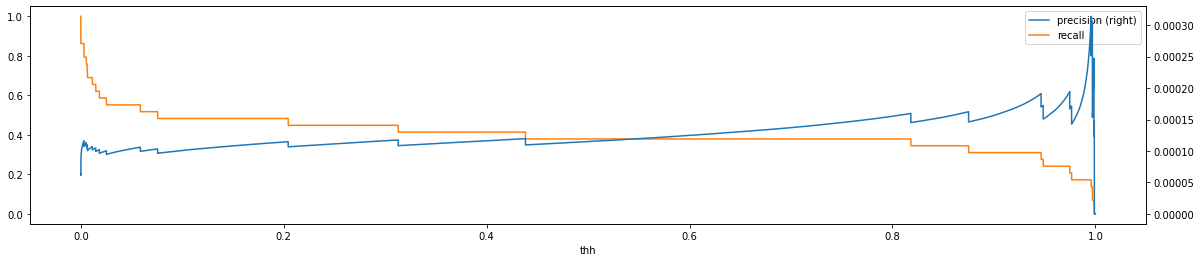

In [42]:
df_s_prt.iloc[:-1,:].drop(columns=['thh']).plot(secondary_y='precision', figsize=(20,4))

100%|██████████████████████████████████| 9000/9000 [00:00<00:00, 10481.12it/s]


<AxesSubplot:>

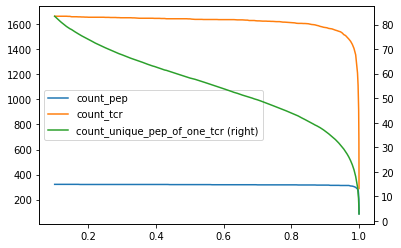

In [43]:
DICT_count_per_thh = {}
for THH in tqdm(np.arange(0.1, 1.0, 0.005)):
    temp = df_s[(df_s.ypred >= THH)]
    count_pospred = temp.shape[0]
    
    count_tcr = temp['tcra:tcrb'].nunique()
    count_pospred_per_tcr = count_pospred / count_tcr
    count_pep = temp['peptide'].nunique()
    count_unique_pep_of_one_tcr =\
    (temp.groupby(by=['tcra:tcrb'])['peptide'].nunique()).mean()
    DICT_count_per_thh[THH] = (count_pospred, count_tcr, count_pospred_per_tcr, count_pep, count_unique_pep_of_one_tcr)
        
for THH in tqdm(np.arange(0.1, 1.0, 0.0001)):
    if THH <= 0.995:continue
    temp = df_s[(df_s.ypred >= THH)]
    count_pospred = temp.shape[0]
    
    count_tcr = temp['tcra:tcrb'].nunique()
    count_pospred_per_tcr = count_pospred / count_tcr
    count_pep = temp['peptide'].nunique()
    count_unique_pep_of_one_tcr =\
    (temp.groupby(by=['tcra:tcrb'])['peptide'].nunique()).mean()
    DICT_count_per_thh[THH] = (count_pospred, count_tcr, count_pospred_per_tcr, count_pep, count_unique_pep_of_one_tcr)
    

df_count = pd.DataFrame(DICT_count_per_thh).T
df_count.columns = ['count_pospred', 'count_tcr', 'count_pospred_per_tcr', 'count_pep', 'count_unique_pep_of_one_tcr']

df_count[['count_pep', 'count_tcr','count_unique_pep_of_one_tcr']].plot(
    secondary_y=['count_unique_pep_of_one_tcr'])



In [86]:
POS_THH = 0.995844
# POS_THH = 0.9999
df_count.tail(1) #[POS_THH]

,count_pospred,count_tcr,count_pospred_per_tcr,count_pep,count_unique_pep_of_one_tcr
0.9999,801.0,289.0,2.771626,86.0,2.771626


In [87]:
precision = precision_score(df_s.sign, df_s.ypred>=POS_THH)
recall = recall_score(df_s.sign, df_s.ypred>=POS_THH)
print(f'with thh = {POS_THH}, precision={precision}, recall={recall}')

with thh = 0.995844, precision=0.00031424800452517124, recall=0.1724137931034483


# Result !  dfall  !

In [88]:
df_pos_pred = dfall.query(f'ypred > {POS_THH}')

In [89]:
print('Ratio of pos_pred over all data count')
df_pos_pred['source'].value_counts() / dfall['source'].value_counts()

Ratio of pos_pred over all data count


df_Negjem_20211327_tables3TCR_X_SProteinPeptides                  0.029807
df_Negjem_20211327_tables3TCR_X_NProteinPeptides                  0.029295
df_Negjem_20211327_tables3TCR_X_MProteinPeptides                  0.027355
df_Neg10clonotypes_X_Spikepeptides_exceptforthehitcombinations    0.068156
df_NegclonotypeNo5_X_Othercovidepeptides                          0.034014
df_PosNeg_clonotypeNo5_X_peptides                                 0.230769
df_Pos10clonotypes_X_Hitpeptides                                  0.066667
Name: source, dtype: float64

In [90]:
all_spike_protein_pep15 = [
    all_spike_protein[i:i+15] for i in range(len(all_spike_protein)) 
    if len(all_spike_protein[i:i+15])==15 and i%4==0
]
DICT_all_spike_protein_pep15 = {pep:1+i*4 for i, pep in enumerate(all_spike_protein_pep15)}

In [91]:
dfall['peptide_pos_spike'] = dfall['peptide'].map(DICT_all_spike_protein_pep15)
print(dfall.shape[0], end=' -> ')
dfall = dfall.drop_duplicates(subset=['source','tcra','tcrb','peptide','peptide_pos_spike',], keep='first')
print(dfall.shape[0])

786356 -> 786356


In [95]:
precision = precision_score(dfall.sign, dfall.ypred>=POS_THH)
recall = recall_score(dfall.sign, dfall.ypred>=POS_THH)
print(f'with thh = {POS_THH}, precision={precision}, recall={recall}')

with thh = 0.995844, precision=0.0002144726118474671, recall=0.1724137931034483


In [101]:
dfall['tcra:tcrb'] = dfall['tcra'] +':'+ dfall['tcrb'] 

In [102]:
dfall[['tcra:tcrb','peptide', 'source']].nunique(), dfall.shape[0]

(tcra:tcrb    1676
 peptide       499
 source          7
 dtype: int64,
 786356)

In [104]:
df_pos_pred.shape

(23313, 32)

In [92]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
import warnings
warnings.simplefilter('ignore')

for s in dfall.source.unique():
    precisions={}
    recalls = {}
    temp = dfall[dfall.source==s]
    for THH in np.arange(0.1, 1.0, 0.1):
        precisions[THH] = precision_score(temp.sign==1.0, temp.ypred>THH)
        recalls[THH] = recall_score(temp.sign==1.0, temp.ypred>THH)
    
    print('='*50)
    print(' ', s)
    print('='*50)
    p = pd.DataFrame(precisions.items()).rename(columns={0:'Threshold', 1:'Precision'})
    p.index = p.Threshold
    p = p.drop(columns=['Threshold'])
    r = pd.DataFrame(recalls.items()).rename(columns={0:'Threshold', 1:'Recall'})
    r.index = r.Threshold
    r = r.drop(columns=['Threshold'])
    r['Precision'] = p.Precision
    display(r.T)


  df_PosNeg_clonotypeNo5_X_peptides


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Recall,0.785714,0.785714,0.714286,0.642857,0.571429,0.571429,0.571429,0.571429,0.500000
Precision,0.611111,0.611111,0.588235,0.562500,0.533333,0.615385,0.615385,0.615385,0.583333


  df_Pos10clonotypes_X_Hitpeptides


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Recall,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.133333
Precision,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000


  df_Neg10clonotypes_X_Spikepeptides_exceptforthehitcombinations


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Recall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Precision,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  df_NegclonotypeNo5_X_Othercovidepeptides


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Recall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Precision,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  df_Negjem_20211327_tables3TCR_X_NProteinPeptides


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Recall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Precision,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  df_Negjem_20211327_tables3TCR_X_MProteinPeptides


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Recall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Precision,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  df_Negjem_20211327_tables3TCR_X_SProteinPeptides


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Recall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Precision,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
for s in dfall.source.unique():
    pos_count={}
    neg_count = {}
    unique_count_pep = []
    unique_count_tcrpairs = []
    temp = dfall[dfall.source==s]
    for THH in np.arange(0.1, 1.0, 0.1):
        pos_count[THH] = (temp.ypred>THH).sum()
        neg_count[THH] = (temp.ypred<=THH).sum()
        dfunique = temp[temp.ypred>THH]
        unique_count_pep.append(dfunique['peptide'].nunique())
        dfunique['tcrpairs'] = dfunique.tcra + ':' + dfunique.tcrb
        unique_count_tcrpairs.append(dfunique['tcrpairs'].nunique())
    
    print('='*50)
    print(' ', s)
    print('='*50)
    
    dfunique = temp[temp.ypred>THH]
    
    p = pd.DataFrame(pos_count.items()).rename(columns={0:'Threshold', 1:'Pos count'})
    p.index = p.Threshold
    p = p.drop(columns=['Threshold'])
    
    r = pd.DataFrame(neg_count.items()).rename(columns={0:'Threshold', 1:'Neg count'})
    r.index = r.Threshold
    r = r.drop(columns=['Threshold'])
    r['Pos count'] = p['Pos count']
    
    r['unique_count_pep'] = unique_count_pep
    r['unique_count_tcrpairs'] = unique_count_tcrpairs
    r['Pos count per TCR']  = r['Pos count'] / r['unique_count_tcrpairs']
    display(r.T)
    

for s in dfall.source.unique():
    pos_count={}
    neg_count = {}
    unique_count_pep = []
    unique_count_tcrpairs = []
    temp = dfall[dfall.source==s]
    for THH in np.arange(0.1, 1.0, 0.001):
        if THH <=0.99: continue
        pos_count[THH] = (temp.ypred>THH).sum()
        neg_count[THH] = (temp.ypred<=THH).sum()
        dfunique = temp[temp.ypred>THH]
        unique_count_pep.append(dfunique['peptide'].nunique())
        dfunique['tcrpairs'] = dfunique.tcra + ':' + dfunique.tcrb
        unique_count_tcrpairs.append(dfunique['tcrpairs'].nunique())
    
    print('='*50)
    print(' ', s)
    print('='*50)
    
    dfunique = temp[temp.ypred>THH]
    
    p = pd.DataFrame(pos_count.items()).rename(columns={0:'Threshold', 1:'Pos count'})
    p.index = p.Threshold
    p = p.drop(columns=['Threshold'])
    
    r = pd.DataFrame(neg_count.items()).rename(columns={0:'Threshold', 1:'Neg count'})
    r.index = r.Threshold
    r = r.drop(columns=['Threshold'])
    r['Pos count'] = p['Pos count']
    
    r['unique_count_pep'] = unique_count_pep
    r['unique_count_tcrpairs'] = unique_count_tcrpairs
    r['Pos count per TCR']  = r['Pos count'] / r['unique_count_tcrpairs']
    display(r.T)


  df_PosNeg_clonotypeNo5_X_peptides


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Neg count,8.0,8.0,9.0,10.0,11.0,13.0,13.0,13.0,14.0
Pos count,18.0,18.0,17.0,16.0,15.0,13.0,13.0,13.0,12.0
unique_count_pep,11.0,11.0,10.0,10.0,9.0,8.0,8.0,8.0,7.0
unique_count_tcrpairs,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
Pos count per TCR,9.0,9.0,8.5,8.0,7.5,6.5,6.5,6.5,6.0


  df_Pos10clonotypes_X_Hitpeptides


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Neg count,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,13.0
Pos count,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0
unique_count_pep,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
unique_count_tcrpairs,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0
Pos count per TCR,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


  df_Neg10clonotypes_X_Spikepeptides_exceptforthehitcombinations


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Neg count,2777.0,2943.000000,3052.000000,3133.000000,3210.000000,3281.0,3375.000000,3478.000000,3605.000000
Pos count,1610.0,1444.000000,1335.000000,1254.000000,1177.000000,1106.0,1012.000000,909.000000,782.000000
unique_count_pep,280.0,271.000000,267.000000,259.000000,257.000000,248.0,243.000000,231.000000,213.000000
unique_count_tcrpairs,14.0,14.000000,14.000000,14.000000,14.000000,14.0,14.000000,14.000000,14.000000
Pos count per TCR,115.0,103.142857,95.357143,89.571429,84.071429,79.0,72.285714,64.928571,55.857143


  df_NegclonotypeNo5_X_Othercovidepeptides


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Neg count,201.000000,213.000000,218.000000,220.000000,224.000000,227.000000,232.000000,240.000000,254.000000
Pos count,93.000000,81.000000,76.000000,74.000000,70.000000,67.000000,62.000000,54.000000,40.000000
unique_count_pep,17.000000,17.000000,15.000000,14.000000,14.000000,14.000000,14.000000,13.000000,11.000000
unique_count_tcrpairs,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,12.000000
Pos count per TCR,7.153846,6.230769,5.846154,5.692308,5.384615,5.153846,4.769231,4.153846,3.333333


  df_Negjem_20211327_tables3TCR_X_NProteinPeptides


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Neg count,124697.000000,130088.000000,133584.000000,136462.00000,139041.000000,141646.000000,144337.000000,147425.000000,152066.000000
Pos count,46255.000000,40864.000000,37368.000000,34490.00000,31911.000000,29306.000000,26615.000000,23527.000000,18886.000000
unique_count_pep,102.000000,102.000000,102.000000,102.00000,102.000000,101.000000,101.000000,100.000000,100.000000
unique_count_tcrpairs,1648.000000,1638.000000,1631.000000,1618.00000,1601.000000,1587.000000,1564.000000,1539.000000,1481.000000
Pos count per TCR,28.067354,24.947497,22.911097,21.31644,19.931918,18.466289,17.017263,15.287199,12.752194


  df_Negjem_20211327_tables3TCR_X_MProteinPeptides


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Neg count,67067.000000,69598.000000,71171.000000,72407.000000,73532.000000,74654.000000,75862.000000,77203.000000,79050.000000
Pos count,20085.000000,17554.000000,15981.000000,14745.000000,13620.000000,12498.000000,11290.000000,9949.000000,8102.000000
unique_count_pep,52.000000,51.000000,51.000000,50.000000,50.000000,50.000000,49.000000,49.000000,47.000000
unique_count_tcrpairs,1632.000000,1616.000000,1601.000000,1584.000000,1572.000000,1550.000000,1529.000000,1497.000000,1416.000000
Pos count per TCR,12.306985,10.862624,9.981886,9.308712,8.664122,8.063226,7.383911,6.645959,5.721751


  df_Negjem_20211327_tables3TCR_X_SProteinPeptides


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Neg count,386361.000000,402482.000000,413137.000000,421546.000000,429092.00000,436577.000000,444349.000000,453595.00000,466833.000000
Pos count,137169.000000,121048.000000,110393.000000,101984.000000,94438.00000,86953.000000,79181.000000,69935.00000,56697.000000
unique_count_pep,314.000000,313.000000,313.000000,313.000000,313.00000,312.000000,311.000000,311.00000,310.000000
unique_count_tcrpairs,1650.000000,1642.000000,1638.000000,1633.000000,1629.00000,1623.000000,1613.000000,1599.00000,1560.000000
Pos count per TCR,83.132727,73.719854,67.394994,62.451929,57.97299,53.575478,49.089275,43.73671,36.344231


  df_PosNeg_clonotypeNo5_X_peptides


Threshold,0.990,0.991,0.992,0.993,0.994,0.995,0.996,0.997,0.998,0.999
Neg count,20.0,20.0,20.0,20.0,20.0,20.0,21.0,21.0,23.0,25.0
Pos count,6.0,6.0,6.0,6.0,6.0,6.0,5.0,5.0,3.0,1.0
unique_count_pep,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,1.0
unique_count_tcrpairs,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
Pos count per TCR,3.0,3.0,3.0,3.0,3.0,3.0,2.5,2.5,1.5,1.0


  df_Pos10clonotypes_X_Hitpeptides


Threshold,0.990,0.991,0.992,0.993,0.994,0.995,0.996,0.997,0.998,0.999
Neg count,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,15.0,15.0
Pos count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
unique_count_pep,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
unique_count_tcrpairs,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
Pos count per TCR,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN


  df_Neg10clonotypes_X_Spikepeptides_exceptforthehitcombinations


Threshold,0.990,0.991,0.992,0.993,0.994,0.995,0.996,0.997,0.998,0.999
Neg count,3973.000000,3985.000000,3992.000000,4011.000000,4035.000000,4064.000000,4089.000000,4122.000000,4166.000000,4234.0
Pos count,414.000000,402.000000,395.000000,376.000000,352.000000,323.000000,298.000000,265.000000,221.000000,153.0
unique_count_pep,149.000000,146.000000,143.000000,138.000000,132.000000,123.000000,118.000000,108.000000,100.000000,72.0
unique_count_tcrpairs,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,12.000000,12.000000,11.000000,10.0
Pos count per TCR,31.846154,30.923077,30.384615,28.923077,27.076923,24.846154,24.833333,22.083333,20.090909,15.3


  df_NegclonotypeNo5_X_Othercovidepeptides


Threshold,0.990,0.991,0.992,0.993,0.994,0.995,0.996,0.997,0.998,0.999
Neg count,281.000000,282.0,282.0,282.0,282.0,283.00,284.000000,284.000000,284.000000,286.0
Pos count,13.000000,12.0,12.0,12.0,12.0,11.00,10.000000,10.000000,10.000000,8.0
unique_count_pep,6.000000,6.0,6.0,6.0,6.0,6.00,5.000000,5.000000,5.000000,5.0
unique_count_tcrpairs,6.000000,5.0,5.0,5.0,5.0,4.00,3.000000,3.000000,3.000000,2.0
Pos count per TCR,2.166667,2.4,2.4,2.4,2.4,2.75,3.333333,3.333333,3.333333,4.0


  df_Negjem_20211327_tables3TCR_X_NProteinPeptides


Threshold,0.990,0.991,0.992,0.993,0.994,0.995,0.996,0.997,0.998,0.999
Neg count,163245.000000,163599.000000,163999.000000,164430.000000,164893.000000,165415.000000,166066.000000,166752.00000,167663.000000,168863.000000
Pos count,7707.000000,7353.000000,6953.000000,6522.000000,6059.000000,5537.000000,4886.000000,4200.00000,3289.000000,2089.000000
unique_count_pep,96.000000,93.000000,91.000000,91.000000,90.000000,88.000000,87.000000,85.00000,81.000000,72.000000
unique_count_tcrpairs,1153.000000,1124.000000,1099.000000,1081.000000,1053.000000,1008.000000,958.000000,892.00000,780.000000,601.000000
Pos count per TCR,6.684302,6.541815,6.326661,6.033302,5.754036,5.493056,5.100209,4.70852,4.216667,3.475874


  df_Negjem_20211327_tables3TCR_X_MProteinPeptides


Threshold,0.990,0.991,0.992,0.993,0.994,0.995,0.996,0.997,0.998,0.999
Neg count,83570.000000,83719.000000,83882.000000,84077.000000,84287.000000,84543.000000,84816.000000,85157.000000,85657.000000,86252.00000
Pos count,3582.000000,3433.000000,3270.000000,3075.000000,2865.000000,2609.000000,2336.000000,1995.000000,1495.000000,900.00000
unique_count_pep,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,45.000000,43.000000,43.000000,37.00000
unique_count_tcrpairs,1063.000000,1044.000000,1023.000000,997.000000,948.000000,901.000000,836.000000,764.000000,648.000000,452.00000
Pos count per TCR,3.369708,3.288314,3.196481,3.084253,3.022152,2.895671,2.794258,2.611257,2.307099,1.99115


  df_Negjem_20211327_tables3TCR_X_SProteinPeptides


Threshold,0.990,0.991,0.992,0.993,0.994,0.995,0.996,0.997,0.998,0.999
Neg count,499484.000000,500631.000000,501808.000000,503172.000000,504679.000000,506295.000000,508232.000000,510539.000000,513405.000000,517163.000000
Pos count,24046.000000,22899.000000,21722.000000,20358.000000,18851.000000,17235.000000,15298.000000,12991.000000,10125.000000,6367.000000
unique_count_pep,295.000000,294.000000,292.000000,287.000000,285.000000,283.000000,280.000000,273.000000,260.000000,224.000000
unique_count_tcrpairs,1343.000000,1322.000000,1294.000000,1275.000000,1248.000000,1215.000000,1168.000000,1110.000000,1010.000000,855.000000
Pos count per TCR,17.904691,17.321483,16.786708,15.967059,15.104968,14.185185,13.097603,11.703604,10.024752,7.446784


# Count by position

## M protein

- https://pubchem.ncbi.nlm.nih.gov/protein/P0DTC5#section=PRO-ID

Count of unique peptides in positive_in_M_protein 46


<AxesSubplot:>

848 46
Unique TCRab protein in M-protein-pos 848


TopHit


,position,count,peptide
0,204,489,KLNTDHSSSSDNIAL
1,52,253,FLWLLWPVTLACFVL
2,168,227,TVATSRTLSYYKLGA
3,84,218,ACLVGLMWLSYFIAS
4,60,108,TLACFVLAAVYRINW
5,20,103,NLVIGFLFLTWICLL
6,80,103,AIAMACLVGLMWLSY
7,160,93,IKDLPKEITVATSRT
8,128,78,LTRPLLESELVIGAV
9,100,76,RLFARTRSMWSFNPE


<AxesSubplot:xlabel='index'>

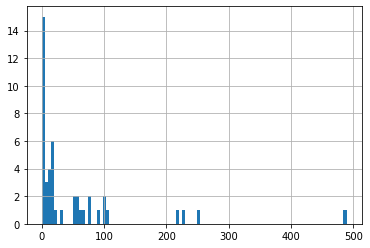

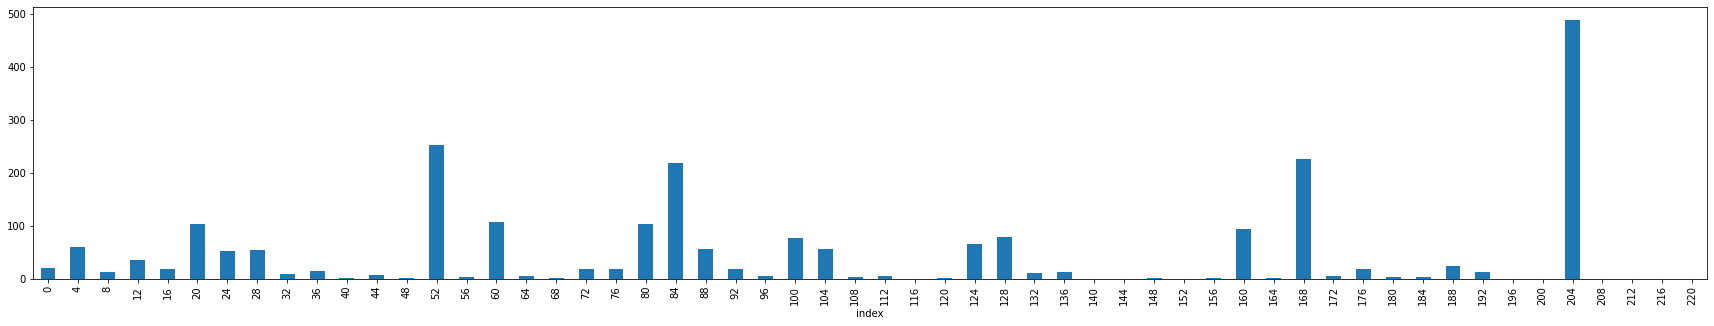

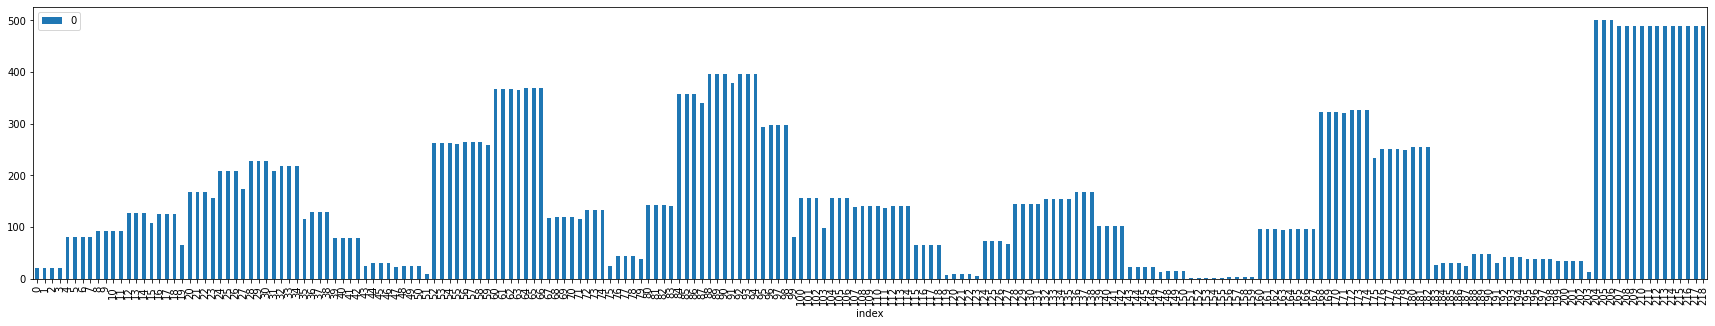

In [57]:
positive_in_M_protein = df_pos_pred.query('source=="df_Negjem_20211327_tables3TCR_X_MProteinPeptides"').copy()
print('Count of unique peptides in positive_in_M_protein', positive_in_M_protein['peptide'].nunique()
     )

display(positive_in_M_protein['peptide'].value_counts().hist(bins=100))

positive_in_M_protein = add_info(positive_in_M_protein.copy(), M_PROTEIN)

positive_in_M_protein['tcrpairs'] = positive_in_M_protein['tcra'] + ':' + positive_in_M_protein['tcrb']

print(positive_in_M_protein['tcrpairs'].nunique(), positive_in_M_protein['peptide'].nunique())

print('Unique TCRab protein in M-protein-pos', positive_in_M_protein.tcrpairs.nunique())

peptide_to_positioM_n = {n:M_PROTEIN.find(n) for n in positive_in_M_protein['peptide'].unique() if len(n) > 14}
pos_to_pep = {v:k for k,v in peptide_to_positioM_n.items()}

count_df = positive_in_M_protein['position_index'].value_counts().reset_index().rename(
    columns={'index':'position', 'position_index':'count'})
count_df['peptide'] = count_df['position'].map(pos_to_pep)

print()
print()
print('TopHit')
display(count_df.head(10))


temp = positive_in_M_protein['position_index'].value_counts().reset_index()
for i in [i for i in range(len(M_PROTEIN)) if i%4==0]:
    if len(temp[temp['index']==i])>0:
        continue
    else:
        temp = temp.append({'index':i, 'position_index':0}, ignore_index=True)
        
temp.sort_values(by=['index']).plot.bar(x='index', figsize=(30,5), legend=False)

positions = [list(range(n, n+15)) for n in positive_in_M_protein['position_index']]
values_positions_M = pd.value_counts(sum(positions, [])).reset_index().sort_values(by=['index'])

for i in range(len(M_PROTEIN)):
    if i in values_positions_M['index']:
        continue
    else:
        values_positions_M.append({'position':i,0:0}, ignore_index=True)

display(values_positions_M.plot.bar(x='index', figsize=(30,5)))

## Nprotein Position

https://pubchem.ncbi.nlm.nih.gov/protein/P0DTC9#section=Sequence

In [53]:
positive_in_N_protein = df_pos_pred.query('source=="df_Negjem_20211327_tables3TCR_X_NProteinPeptides"').copy()
print('Count of unique peptides in positive_in_N_protein', positive_in_N_protein['peptide'].nunique()
     )

Count of unique peptides in positive_in_N_protein 87


<AxesSubplot:>

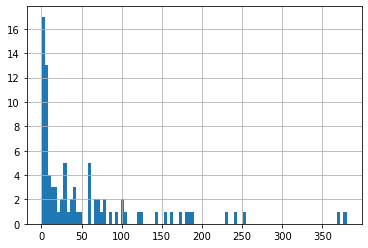

In [54]:
positive_in_N_protein['peptide'].value_counts().hist(bins=100)

<AxesSubplot:title={'center':'N Protein'}, xlabel='index'>

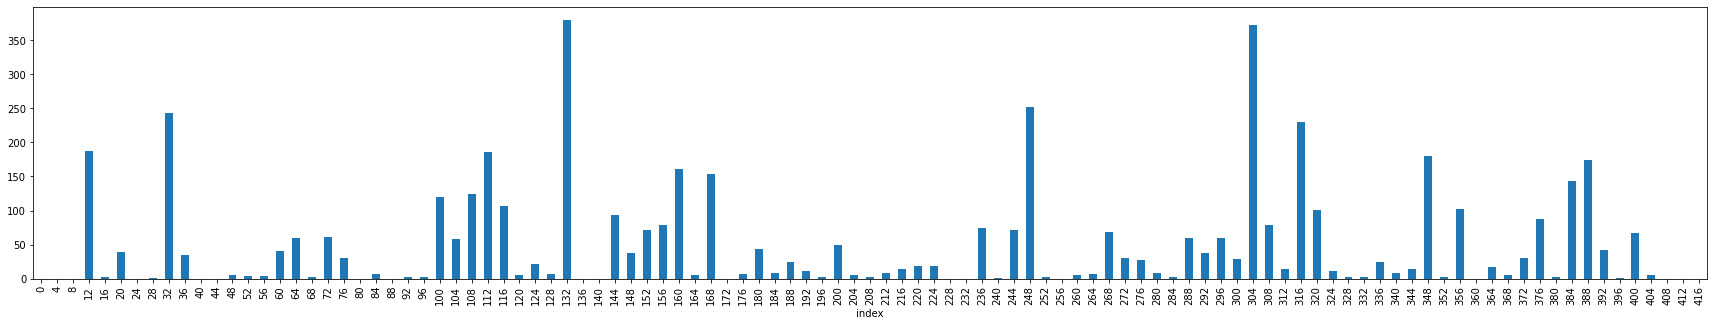

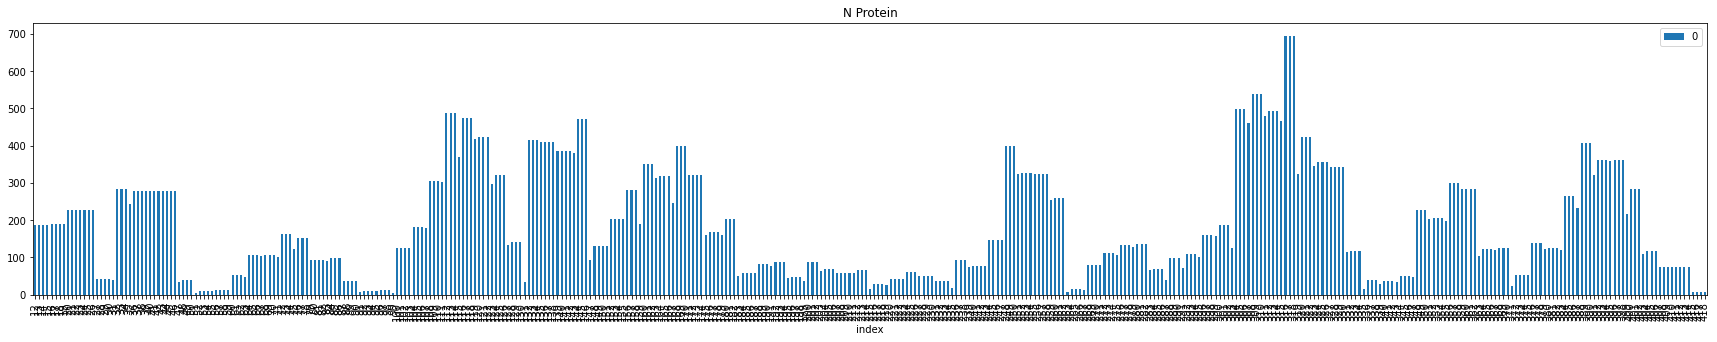

In [55]:

def add_info(positive_in_N_protein, N_PROTEIN):
    peptide_to_position_n = {n:N_PROTEIN.find(n) for n in positive_in_N_protein['peptide'].unique() if len(n) > 14}
    positive_in_N_protein['position_index'] = positive_in_N_protein['peptide'].map(peptide_to_position_n)
    positive_in_N_protein = positive_in_N_protein.dropna(subset=['position_index'])
    positive_in_N_protein['position_index'] = positive_in_N_protein['position_index'].astype(int)
    return positive_in_N_protein

positive_in_N_protein = add_info(positive_in_N_protein.copy(), N_PROTEIN)
peptide_to_position_n = {n:N_PROTEIN.find(n) for n in positive_in_N_protein['peptide'].unique() if len(n) > 14}
pos_to_pep = {v:k for k,v in peptide_to_position_n.items()}

count_df = positive_in_N_protein['position_index'].value_counts().reset_index().rename(
    columns={'index':'position', 'position_index':'count'})

count_df['peptide'] = count_df['position'].map(pos_to_pep)
count_df.head(10)

temp = positive_in_N_protein['position_index'].value_counts().reset_index()

for i in [i for i in range(len(N_PROTEIN)) if i%4==0]:
    if len(temp[temp['index']==i])>0:
        continue
    else:
        temp = temp.append({'index':i, 'position_index':0}, ignore_index=True)
        
        
    
temp.sort_values(by=['index']).plot.bar(x='index', figsize=(30,5), legend=False)

positions = [list(range(n, n+15)) for n in positive_in_N_protein['position_index']]
values_positions_N = pd.value_counts(sum(positions, [])).reset_index().sort_values(by=['index'])

for i in range(len(N_PROTEIN)):
    if i in values_positions_N['index']:
        continue
    else:
        values_positions_N.append({'position':i,0:0}, ignore_index=True)

values_positions_N.plot.bar(x='index', figsize=(30,5), title='N Protein')

In [56]:
positive_in_N_protein['tcrpairs'] = positive_in_N_protein['tcra'] + ':' + positive_in_N_protein['tcrb']

positive_in_N_protein['tcrpairs'].nunique(), positive_in_N_protein['peptide'].nunique(), 

(967, 87)

## S protein

Count of unique peptides in positive_in_S_protein 281


<AxesSubplot:>

1181 281
Unique TCRab protein in S-protein-pos 1181


TopHit


,position,count,peptide
0,720,502,SVTTEILPVSMTKTS
1,308,446,EKGIYQTSNFRVQPT
2,416,432,KIADYNYKLPDDFTG
3,960,394,TLVKQLSSNFGAISS
4,84,371,PFNDGVYFASTEKSN
5,52,324,DLFLPFFSNVTWFHA
6,716,323,NFTISVTTEILPVSM
7,1056,323,PHGVVFLHVTYVPAQ
8,1104,321,TQRNFYEPQIITTDN
9,588,319,PCSFGGVSVITPGTN


<AxesSubplot:xlabel='index'>

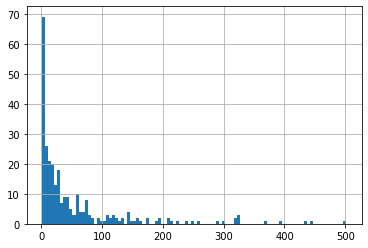

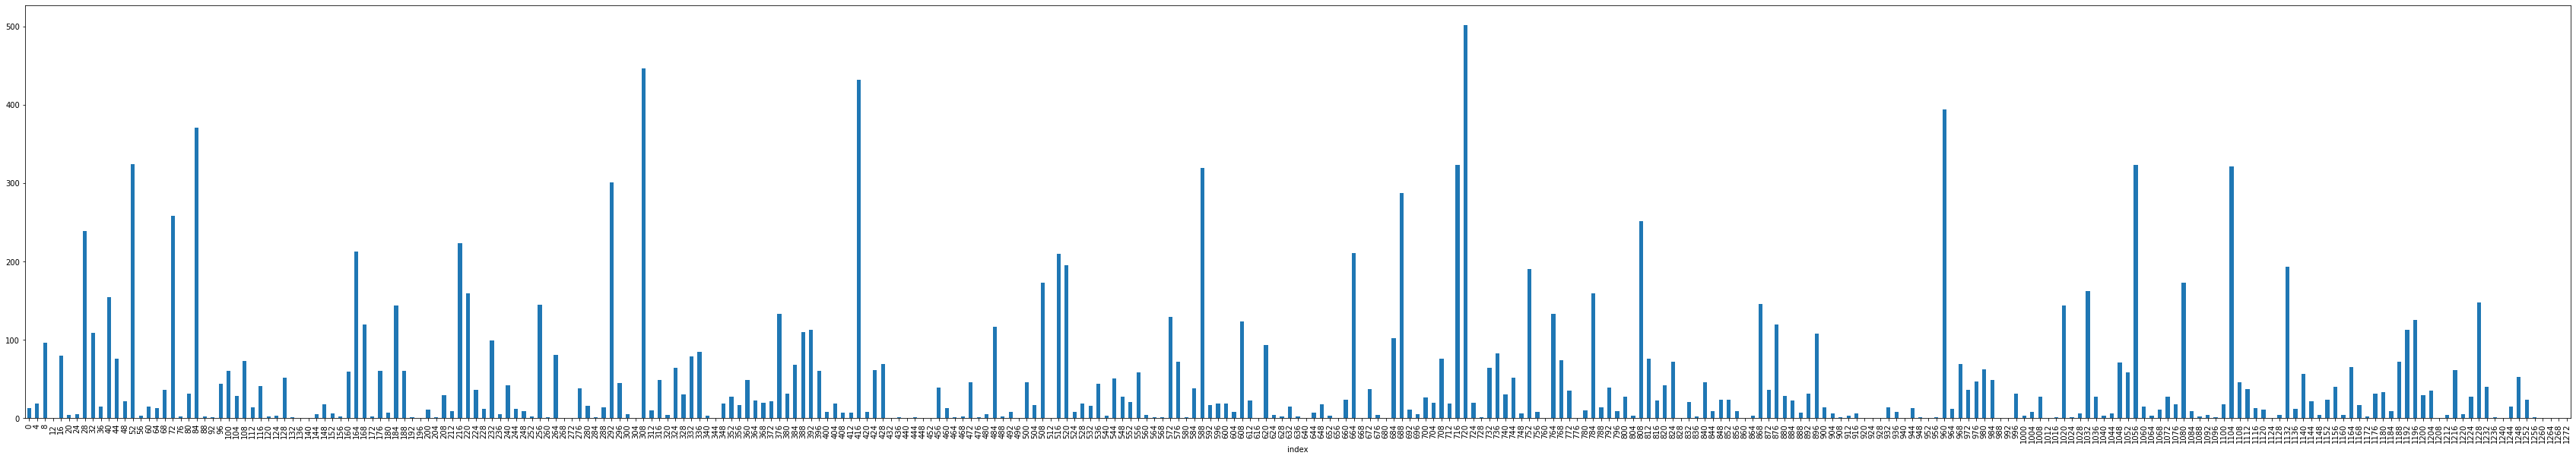

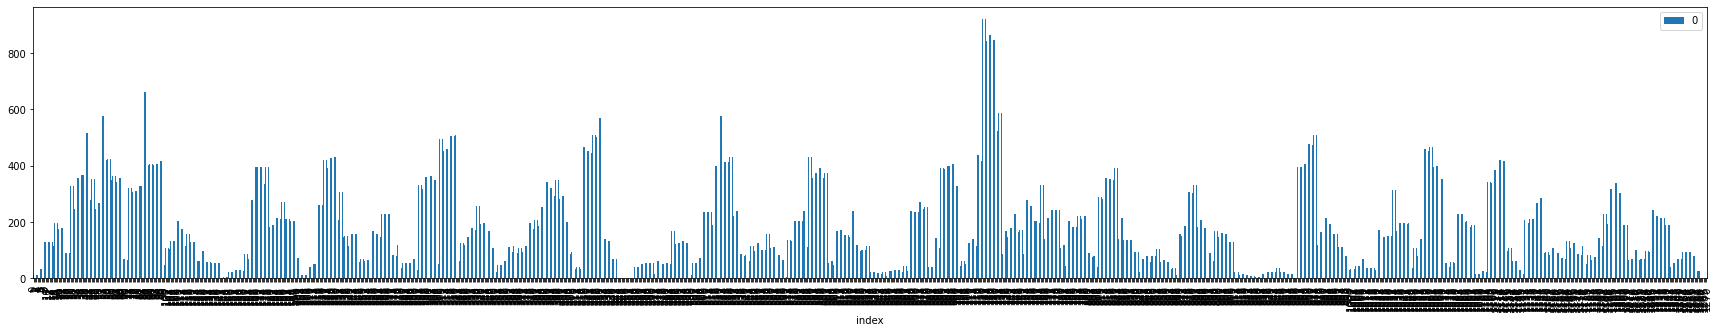

In [58]:
positive_in_S_protein = df_pos_pred.query('source=="df_Negjem_20211327_tables3TCR_X_SProteinPeptides"').copy()
print('Count of unique peptides in positive_in_S_protein', positive_in_S_protein['peptide'].nunique()
     )

display(positive_in_S_protein['peptide'].value_counts().hist(bins=100))

positive_in_S_protein = add_info(positive_in_S_protein.copy(), S_PROTEIN)

positive_in_S_protein['tcrpairs'] = positive_in_S_protein['tcra'] + ':' + positive_in_S_protein['tcrb']

print(positive_in_S_protein['tcrpairs'].nunique(), positive_in_S_protein['peptide'].nunique())

print('Unique TCRab protein in S-protein-pos', positive_in_S_protein.tcrpairs.nunique())

peptide_to_position = {n:S_PROTEIN.find(n) for n in positive_in_S_protein['peptide'].unique() if len(n) > 14}
pos_to_pep = {v:k for k,v in peptide_to_position.items()}


count_df = positive_in_S_protein['position_index'].value_counts().reset_index().rename(
    columns={'index':'position', 'position_index':'count'})
count_df['peptide'] = count_df['position'].map(pos_to_pep)

print()
print()
print('TopHit')
display(count_df.head(10))


temp = positive_in_S_protein['position_index'].value_counts().reset_index()
for i in [i for i in range(len(S_PROTEIN)) if i%4==0]:
    if len(temp[temp['index']==i])>0:
        continue
    else:
        temp = temp.append({'index':i, 'position_index':0}, ignore_index=True)    
temp.sort_values(by=['index']).plot.bar(x='index', figsize=(60,10), legend=False)

positions = [list(range(n, n+15)) for n in positive_in_S_protein['position_index']]
values_positions_S = pd.value_counts(sum(positions, [])).reset_index().sort_values(by=['index'])

for i in range(len(S_PROTEIN)):
    if i in values_positions_S['index']:
        continue
    else:        
        values_positions_S.append({'position':i,0:0}, ignore_index=True)

display(values_positions_S.plot.bar(x='index', figsize=(30,5))
       )

# PDB Command 

In [67]:
from matplotlib import pyplot as plt

def generate_color_at_pos(r=0,g=0,b=0,RES_NUM=0):
    a = f'''set_color blue_{r}_{g}_{b}, [ {r}, {g}, {b} ];
sel hit_pep, (resi {RES_NUM});
color blue_{r}_{g}_{b}, hit_pep; 
''' 
    return a

def cstm_color(x):
    return (255 * np.array(plt.cm.autumn_r(x)))[:-1]
#     return (255 * np.array(plt.cm.afmhot(x)))[:-1]
#     return (255 * np.array(plt.cm.hot(x)))[:-1]

from sklearn.preprocessing import QuantileTransformer


## M Protein

In [68]:
qt = QuantileTransformer(n_quantiles=50, random_state=0)
values_positions_M['preprocessed_quantile_values'] = qt.fit_transform(values_positions_M[0].values.reshape(-1, 1)).ravel()

PDBID = '8CTK'

COMMAND_PYMOL = f"""
fetch {PDBID};
set seq_view, 1;
bg_color white;
"""

for i, row in values_positions_M.iterrows():
    colorval = row['preprocessed_quantile_values']
    RES_NUM = int(row['index'])
    r,g,b = cstm_color(colorval)
    COMMAND_PYMOL += generate_color_at_pos(r,g,b,RES_NUM)


In [69]:
print(COMMAND_PYMOL)


fetch 8CTK;
set seq_view, 1;
bg_color white;
set_color blue_255.0_229.0_0.0, [ 255.0, 229.0, 0.0 ];
sel hit_pep, (resi 0);
color blue_255.0_229.0_0.0, hit_pep; 
set_color blue_255.0_229.0_0.0, [ 255.0, 229.0, 0.0 ];
sel hit_pep, (resi 1);
color blue_255.0_229.0_0.0, hit_pep; 
set_color blue_255.0_229.0_0.0, [ 255.0, 229.0, 0.0 ];
sel hit_pep, (resi 2);
color blue_255.0_229.0_0.0, hit_pep; 
set_color blue_255.0_229.0_0.0, [ 255.0, 229.0, 0.0 ];
sel hit_pep, (resi 3);
color blue_255.0_229.0_0.0, hit_pep; 
set_color blue_255.0_167.0_0.0, [ 255.0, 167.0, 0.0 ];
sel hit_pep, (resi 4);
color blue_255.0_167.0_0.0, hit_pep; 
set_color blue_255.0_167.0_0.0, [ 255.0, 167.0, 0.0 ];
sel hit_pep, (resi 5);
color blue_255.0_167.0_0.0, hit_pep; 
set_color blue_255.0_167.0_0.0, [ 255.0, 167.0, 0.0 ];
sel hit_pep, (resi 6);
color blue_255.0_167.0_0.0, hit_pep; 
set_color blue_255.0_167.0_0.0, [ 255.0, 167.0, 0.0 ];
sel hit_pep, (resi 7);
color blue_255.0_167.0_0.0, hit_pep; 
set_color blue_255.0_161.0

## N Protein

In [70]:
qt = QuantileTransformer(n_quantiles=50, random_state=0)
values_positions_N['preprocessed_quantile_values'] = qt.fit_transform(values_positions_N[0].values.reshape(-1, 1)).ravel()

PDBID = '6M3M'
# PDBID = '6VYO'
COMMAND_PYMOL = f"""
fetch {PDBID};
set seq_view, 1;
bg_color white;
"""

for i, row in values_positions_N.iterrows():
    colorval = row['preprocessed_quantile_values']
    RES_NUM = int(row['index'])
    r,g,b = cstm_color(colorval)
    COMMAND_PYMOL += generate_color_at_pos(r,g,b,RES_NUM)



In [71]:
print(COMMAND_PYMOL)


fetch 6M3M;
set seq_view, 1;
bg_color white;
set_color blue_255.0_103.0_0.0, [ 255.0, 103.0, 0.0 ];
sel hit_pep, (resi 12);
color blue_255.0_103.0_0.0, hit_pep; 
set_color blue_255.0_103.0_0.0, [ 255.0, 103.0, 0.0 ];
sel hit_pep, (resi 13);
color blue_255.0_103.0_0.0, hit_pep; 
set_color blue_255.0_103.0_0.0, [ 255.0, 103.0, 0.0 ];
sel hit_pep, (resi 14);
color blue_255.0_103.0_0.0, hit_pep; 
set_color blue_255.0_103.0_0.0, [ 255.0, 103.0, 0.0 ];
sel hit_pep, (resi 15);
color blue_255.0_103.0_0.0, hit_pep; 
set_color blue_255.0_98.99999999999999_0.0, [ 255.0, 98.99999999999999, 0.0 ];
sel hit_pep, (resi 16);
color blue_255.0_98.99999999999999_0.0, hit_pep; 
set_color blue_255.0_98.99999999999999_0.0, [ 255.0, 98.99999999999999, 0.0 ];
sel hit_pep, (resi 17);
color blue_255.0_98.99999999999999_0.0, hit_pep; 
set_color blue_255.0_98.99999999999999_0.0, [ 255.0, 98.99999999999999, 0.0 ];
sel hit_pep, (resi 18);
color blue_255.0_98.99999999999999_0.0, hit_pep; 
set_color blue_255.0_98.999

## S Pro

In [72]:
# Closed State
# https://www.rcsb.org/structure/6vxx

# Open State
# https://www.rcsb.org/structure/7DDN

<AxesSubplot:>

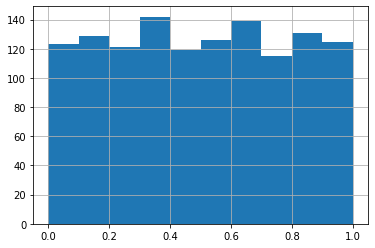

In [80]:
values_positions_S['preprocessed_quantile_values'].hist()

In [83]:
qt = QuantileTransformer(n_quantiles=30, random_state=0)
values_positions_S['preprocessed_quantile_values'] = qt.fit_transform(values_positions_S[0].values.reshape(-1, 1)).ravel()

PDBID = '6VXX'
COMMAND_PYMOL = f"""
fetch {PDBID};
set seq_view, 1;
bg_color white;
"""

for i, row in values_positions_S.iterrows():
    colorval = row['preprocessed_quantile_values']
    RES_SUM = int(row['index'])
    r,g,b = cstm_color(colorval)
    COMMAND_PYMOL += generate_color_at_pos(r,g,b,RES_SUM)



In [84]:
print(COMMAND_PYMOL)


fetch 6VXX;
set seq_view, 1;
bg_color white;
set_color blue_255.0_247.0_0.0, [ 255.0, 247.0, 0.0 ];
sel hit_pep, (resi 0);
color blue_255.0_247.0_0.0, hit_pep; 
set_color blue_255.0_247.0_0.0, [ 255.0, 247.0, 0.0 ];
sel hit_pep, (resi 1);
color blue_255.0_247.0_0.0, hit_pep; 
set_color blue_255.0_247.0_0.0, [ 255.0, 247.0, 0.0 ];
sel hit_pep, (resi 2);
color blue_255.0_247.0_0.0, hit_pep; 
set_color blue_255.0_247.0_0.0, [ 255.0, 247.0, 0.0 ];
sel hit_pep, (resi 3);
color blue_255.0_247.0_0.0, hit_pep; 
set_color blue_255.0_226.0_0.0, [ 255.0, 226.0, 0.0 ];
sel hit_pep, (resi 4);
color blue_255.0_226.0_0.0, hit_pep; 
set_color blue_255.0_226.0_0.0, [ 255.0, 226.0, 0.0 ];
sel hit_pep, (resi 5);
color blue_255.0_226.0_0.0, hit_pep; 
set_color blue_255.0_226.0_0.0, [ 255.0, 226.0, 0.0 ];
sel hit_pep, (resi 6);
color blue_255.0_226.0_0.0, hit_pep; 
set_color blue_255.0_226.0_0.0, [ 255.0, 226.0, 0.0 ];
sel hit_pep, (resi 7);
color blue_255.0_226.0_0.0, hit_pep; 
set_color blue_255.0_140.0